<a href="https://colab.research.google.com/github/santiagoahl/land-cover-segmentation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land cover **segmentation**

>[Land cover segmentation](#scrollTo=u2QwcNCnwcd-)

>[Libraries & Modules](#scrollTo=Bd6fH_rGwgs4)

>[Data import](#scrollTo=k7-uwN5SwiW4)

>[Data-viz](#scrollTo=xzFowXlJwllq)

>[Data preprocessing](#scrollTo=be7p1uhAwnY-)

>[Training](#scrollTo=7dze0c_wwo9h)

>>[CNN](#scrollTo=BqQ5l3nuNksC)

>[IoU](#scrollTo=nYsemT50mVOt)

>>[Vision Transformer](#scrollTo=g2MpLSLdNlzT)

>[Testing](#scrollTo=qs1GYHz2xFJv)

>>[CNN](#scrollTo=CtyvBP0UfC-t)

>>[Vision Transformer](#scrollTo=q-lXEYiwfC-1)

>[Model export](#scrollTo=1wESuRqyxGR4)

>[Model import](#scrollTo=kzw1Ll5ixcCA)



# Libraries & Modules

In [ ]:
%%capture
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv

# CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras import  regularizers
from tensorflow.keras.layers import Conv2D, Dropout, Dense, AveragePooling2D, MaxPooling2D, Flatten, Activation
from tqdm.keras import TqdmCallback 

# Vision transformers

#from transformers.models.vit.feature_extraction_vit import ViTFeatureExtractor
#from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer

import joblib

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from google.colab import drive

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Data import

In [ ]:
!unzip '/content/drive/MyDrive/personal-projects/land-cover-segmentation/data/dataset.zip';

Archive:  /content/drive/MyDrive/personal-projects/land-cover-segmentation/data/dataset.zip
replace class_dict.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
class_path = '/content/class_dict.csv'
data_path = '/content/metadata.csv'

train_data_paths = df[df['split']=='train']
test_data_paths = df[df['split']=='test']

In [ ]:
labels = pd.read_csv(class_path)
labels

name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0

In [ ]:
df = pd.read_csv(data_path)
df.head()

image_id  split        sat_image_path              mask_path
0    100694  train  train/100694_sat.jpg  train/100694_mask.png
1    102122  train  train/102122_sat.jpg  train/102122_mask.png
2     10233  train   train/10233_sat.jpg   train/10233_mask.png
3    103665  train  train/103665_sat.jpg  train/103665_mask.png
4    103730  train  train/103730_sat.jpg  train/103730_mask.png

# Data-viz

In [ ]:
sample_path = train_data['sat_image_path'][3]
sample_image = cv.imread(sample_path)

plt.figure(figsize=(10, 10))
plt.title('Satellital image')
plt.imshow(sample_image)
plt.axis('off')
plt.show()

In [ ]:
sample1 = train_data['sat_image_path'][:200]
sample2 = train_data['mask_path'][:200]

i=-2

fig, ax = plt.subplots(ncols=20, nrows=10, figsize=(20, 10))
for x in range(10):
  i+=1
  for y in range(20):
    i+=1
    if i%2==0:
      path = sample1[5*x+y]
    else:
      path = sample2[5*x+y]
    image = cv.imread(path)
    ax[x, y].imshow(image)
    ax[x, y].axis('off')
plt.suptitle('Satellital images')
fig.show()

Notice that the land segmentation is given by: 

| Class  | Colour |
| --- | --- |
| `urban_land` |  Yellow |
| `agriculture_land` | Cyan |
| `rangeland` | Pink |
| `forest_land` | Green |
| `water` | Blue (or red?) |
| `barren_land` | White |
| `unknown` | Black |


Observe how segmentations are displayed:

In [ ]:
n = 400

#plt.title('Land segmentation')

for n in range(10):
  im1 = cv.imread(train_data['sat_image_path'][n])
  im2 = cv.imread(train_data['mask_path'][n])

  fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))

  ax[0].imshow(im1)
  ax[0].set_title('Satellital image')
  ax[0].axis('off')

  ax[1].imshow(im2)
  ax[1].set_title('Masked image')
  ax[1].axis('off')

fig.show()

In [ ]:
sample = train_data['mask_path'][:200]

fig, ax = plt.subplots(ncols=20, nrows=10, figsize=(20, 10))
for x in range(10):
  for y in range(20):
    path = sample[5*x+y]
    image = cv.imread(path)
    ax[x, y].imshow(image)
    ax[x, y].axis('off')
plt.suptitle('Satellital images')
fig.show()

# Data preprocessing

In [ ]:
train_image_paths, train_mask_paths, val_image_paths, val_mask_paths = (train_data_paths['sat_image_path'], train_data_paths['mask_path'], test_data_paths['sat_image_path'], test_data_paths['mask_path'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_image_paths, train_mask_paths, test_size=0.2, random_state=42)

In [ ]:
X_train

432    train/586222_sat.jpg
582    train/736869_sat.jpg
442    train/599743_sat.jpg
643     train/81039_sat.jpg
334    train/476582_sat.jpg
               ...         
71     train/170535_sat.jpg
106    train/211316_sat.jpg
270     train/40168_sat.jpg
435    train/587968_sat.jpg
102     train/21023_sat.jpg
Name: sat_image_path, Length: 642, dtype: object

In [ ]:
# Reindexing

X_train = pd.Series(X_train.tolist())
X_test = pd.Series(X_test.tolist())

y_train = pd.Series(y_train.tolist())
y_test = pd.Series(y_test.tolist())

In [ ]:
X_train

0      train/586222_sat.jpg
1      train/736869_sat.jpg
2      train/599743_sat.jpg
3       train/81039_sat.jpg
4      train/476582_sat.jpg
               ...         
637    train/170535_sat.jpg
638    train/211316_sat.jpg
639     train/40168_sat.jpg
640    train/587968_sat.jpg
641     train/21023_sat.jpg
Length: 642, dtype: object

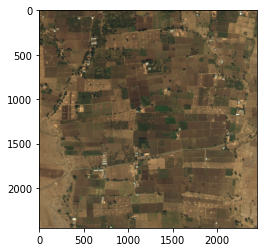

In [ ]:
plt.imshow(plt.imread(X_train[2]))

In [ ]:
def load_data(images_path, masks_path, shape):
  data = {'images': [], 'masks': []}

  for i in range(len(images_path)):
    if i%10==0:
      print(int(i / len(images_path) * 100), '%')
    #Read images
    img = plt.imread(images_path[i])
    mask = plt.imread(masks_path[i])
    #Img Resize
    img = cv.resize(img, shape)
    mask = cv.resize(mask, shape)
    #Save images
    data['images'].append(img)
    data['masks'].append(mask)
  #Save sample as a tensor
  data['images'] = np.array(data['images'])
  data['masks'] = np.array(data['masks'])

  return data

In [ ]:
train_data = load_data(images_path=X_train, masks_path=y_train,
                       shape=(512, 512)
                       )
test_data = load_data(images_path=X_test, masks_path=y_test,
                      shape=(512, 512)
                      )

In [ ]:
train_data['masks'].shape

(642, 512, 512, 3)

In [ ]:
len(X_train)

642

In [ ]:
train_data['masks'][0]

# Training

## U-Net

In [ ]:
def create_conv_block(input_tensor, num_filters):
  """
    Helps us to create the convolutional blocks
  """
  # First Conv layer
  x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  # Second Conv layer

  x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  return x

In [ ]:
def create_unet(input_shape, num_filters=16, dropout=0.1):
  """
    Creates the U-Net Architecture
  """
  # Encoder
    # First conv block
  c1 = create_conv_block(input_shape, num_filters * 1)
  p1 = tf.keras.layers.MaxPool2D((2, 2))(c1)
  p1 = tf.keras.layers.Dropout(dropout)(p1)
    # Second conv block
  c2 = create_conv_block(p1, num_filters * 2)
  p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)
  p2 = tf.keras.layers.Dropout(dropout)(p2)
    # Third conv block
  c3 = create_conv_block(p2, num_filters * 4)
  p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)
  p3 = tf.keras.layers.Dropout(dropout)(p3)
    # Fourth conv block
  c4 = create_conv_block(p3, num_filters * 8)
  p4 = tf.keras.layers.MaxPool2D((2, 2))(c4)
  p4 = tf.keras.layers.Dropout(dropout)(p4)

  c5 = create_conv_block(p4, num_filters*16)

  # Decoder
    # First block
  u6 = tf.keras.layers.Conv2DTranspose(num_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  u6 = tf.keras.layers.Dropout(dropout)(u6)
  c6 = create_conv_block(u6, num_filters*8)
    # Second block
  u7 = tf.keras.layers.Conv2DTranspose(num_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  u7 = tf.keras.layers.Dropout(dropout)(u7)
  c7 = create_conv_block(u7, num_filters*4)
    #Third block
  u8 = tf.keras.layers.Conv2DTranspose(num_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  u8 = tf.keras.layers.Dropout(dropout)(u8)
  c8 = create_conv_block(u8, num_filters*2) 
    # Fourth block
  u9 = tf.keras.layers.Conv2DTranspose(num_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1])
  c9 = tf.keras.layers.Dropout(dropout)(u9)

  output = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)
  model = tf.keras.Model(inputs = [input_shape], outputs=[output])
  
  return model

In [ ]:
input_shape = train_data['masks'][0].shape
inputs = tf.keras.layers.Input(input_shape)

model = create_unet(inputs, num_filters=32)

In [ ]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

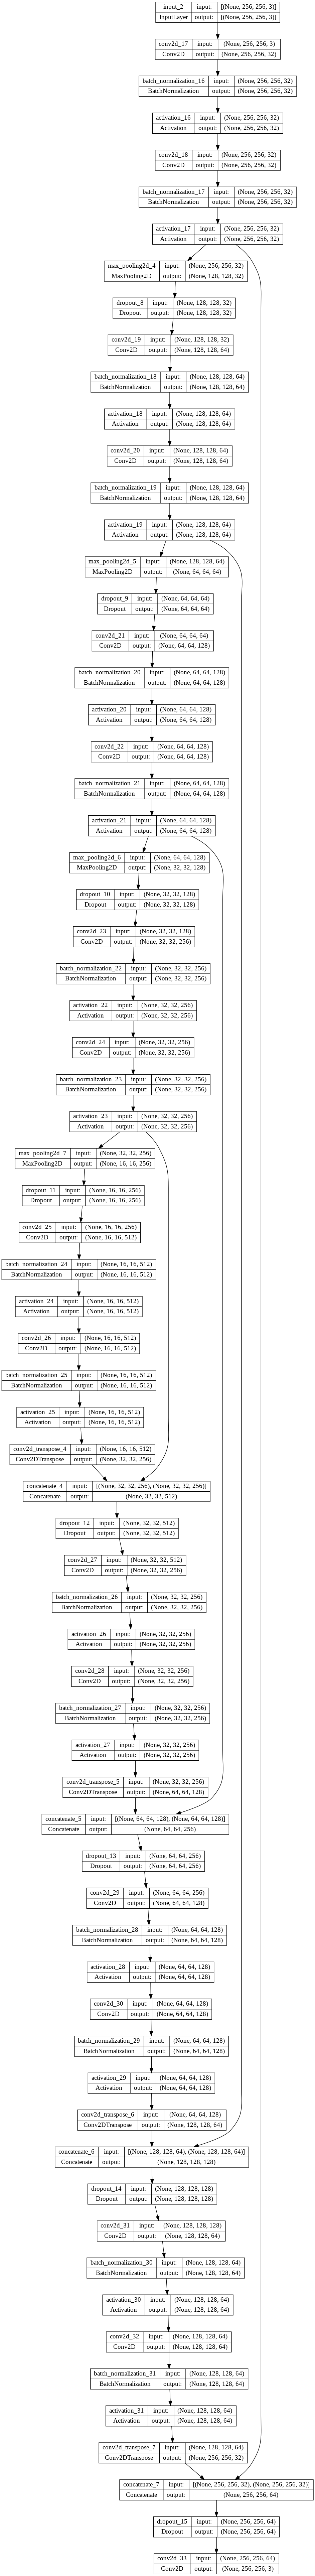

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('best.hdf5', monitor='accuracy', save_best_only=True, verbose=0)

In [ ]:
model_history = model.fit(train_data['images'], train_data['masks'],
                          epochs=200,
                          verbose=0,
                          batch_size=8,
                          callbacks=[checkpoint, TqdmCallback(verbose=1), early]
                        )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

ValueError: ignored

### IoU

In [ ]:
import tensorflow as tf

def iou(y_true, y_pred, smooth=1):
  intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
  union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
  return tf.reduce_mean((intersection + smooth) / (union + smooth))

# Compile the model with the custom IoU metric


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early = EarlyStopping(patience=20)
print(input_shape)

(512, 512, 3)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])

In [ ]:
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                          epochs=200,
                          verbose=0,
                          batch_size=6,
                          callbacks=[checkpoint, early, TqdmCallback(verbose=1)]
                      )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

ValueError: ignored

## Mask R-CNN

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoModel, AutoTokenizer

In [ ]:
model = AutoModel.from_pretrained("facebook/maskformer-swin-large-ade")

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/maskformer-swin-large-ade were not used when initializing MaskFormerModel: ['mask_embedder.1.0.weight', 'mask_embedder.1.0.bias', 'class_predictor.weight', 'criterion.empty_weight', 'mask_embedder.2.0.weight', 'mask_embedder.0.0.bias', 'class_predictor.bias', 'mask_embedder.2.0.bias', 'mask_embedder.0.0.weight']
- This IS expected if you are initializing MaskFormerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MaskFormerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Testing

## CNN

In [ ]:
model_history = model_history.history

In [ ]:
def plot_history(model_history, iteration_message):  
  plt.figure(figsize=(10, 10))

  plt.plot(model_history['loss'], label='Training loss')
  plt.plot(model_history['accuracy'], label='Training accuracy')

  plt.title('U-Net Performance ('+iteration_message+')')
  plt.grid(True)
  plt.savefig('/content/drive/MyDrive/personal-projects/land-cover-segmentation/images/'+str(iteration_message)+'.png')
  plt.show()

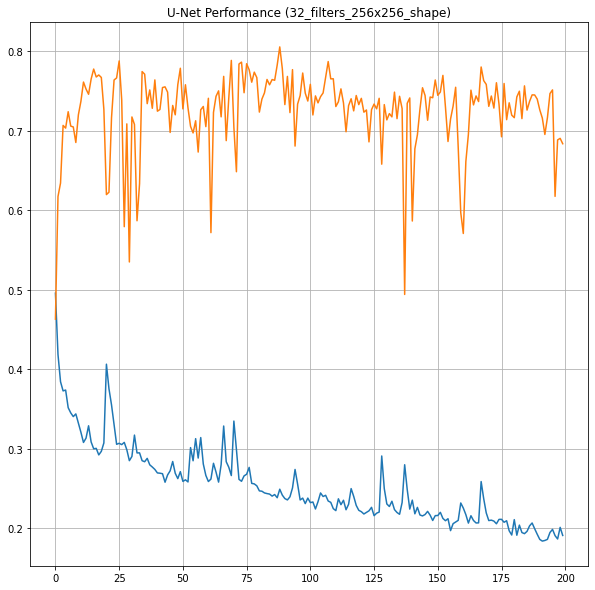

In [ ]:
plot_history(model_history, '32_filters_256x256_shape')

In [ ]:
type(test_data['images'])

numpy.ndarray

In [ ]:
def predict_test_samples(val_map, model):
  imgs = val_map['images']
  masks = val_map['masks']

  predicted_masks = model.predict(imgs)

  return imgs, predicted_masks, masks

In [ ]:
def plot_predictions(image, mask_pred, ground_truth_mask):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

  ax[0].imshow(image)
  ax[0].set_title('Original satellital image')
  ax[0].axis('off')

  ax[1].imshow(mask_pred)
  ax[1].set_title('Predicted Mask')
  ax[1].axis('off')

  ax[2].imshow(ground_truth_mask)
  ax[2].set_title('Ground truth Mask')
  ax[2].axis('off')

  plt.show()

In [ ]:
imgs, predicted_masks, masks = predict_test_samples(test_data, model)

6/6 [==============================] - 2s 291ms/step


In [ ]:
model.evaluate(X_test, y_test)

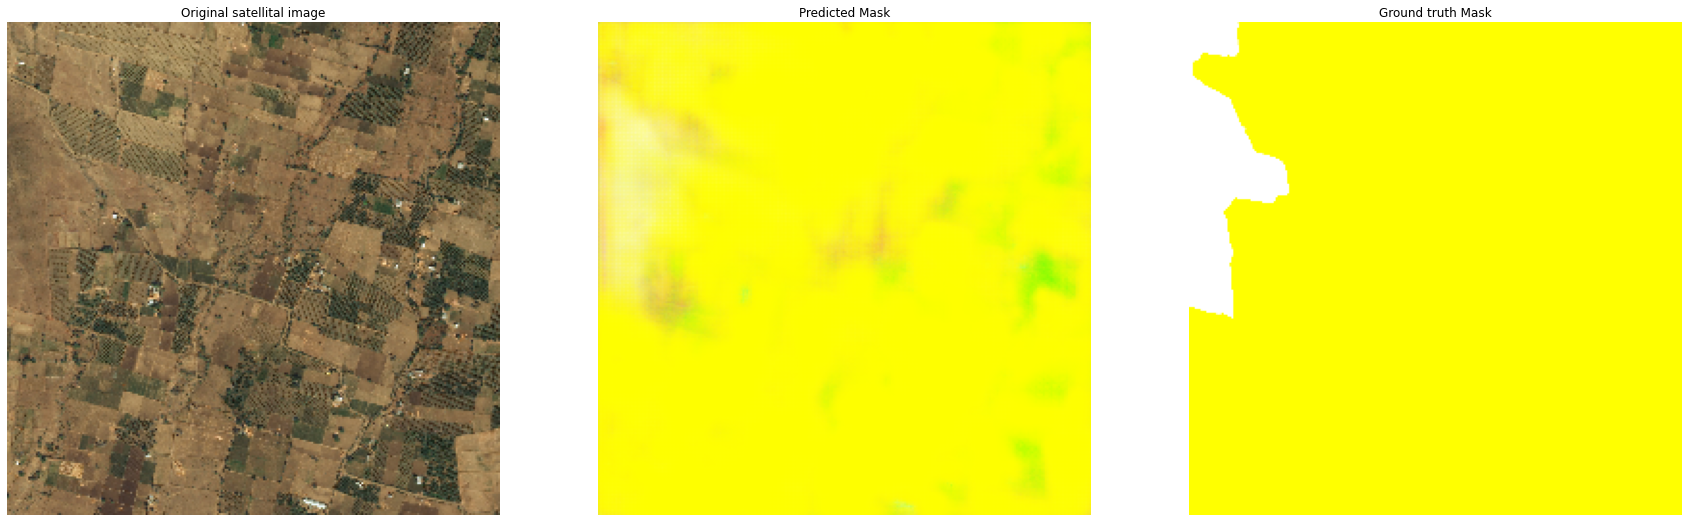

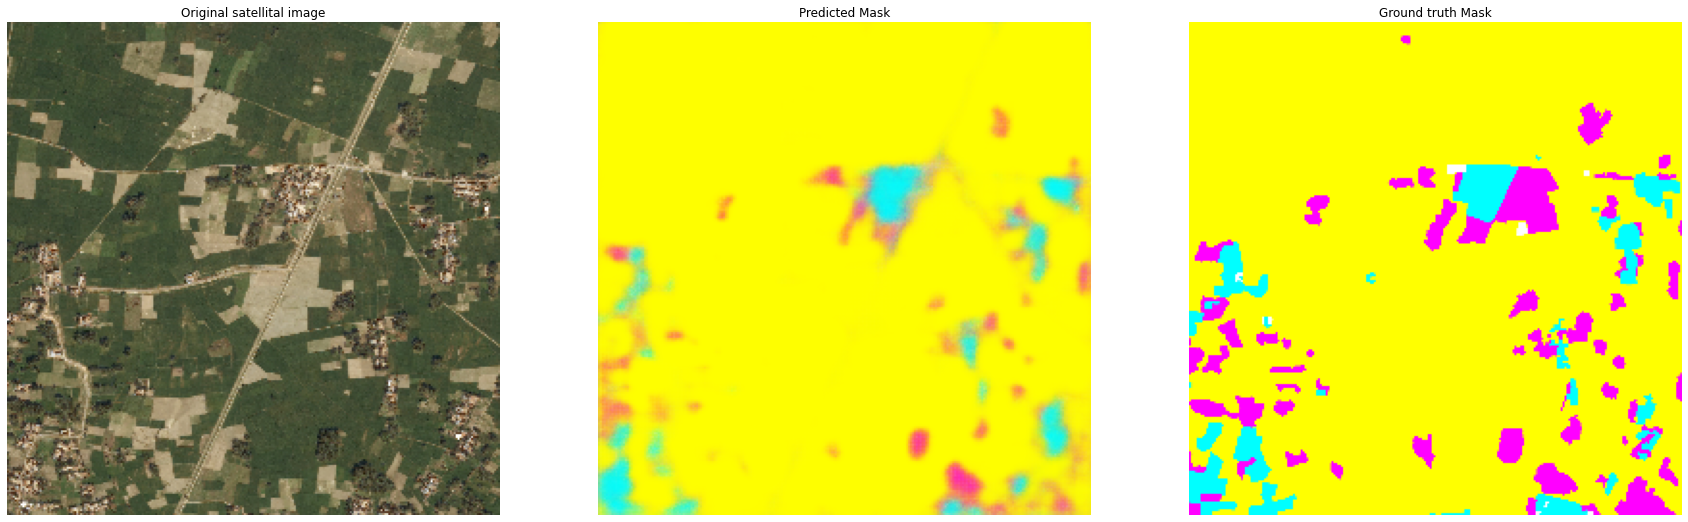

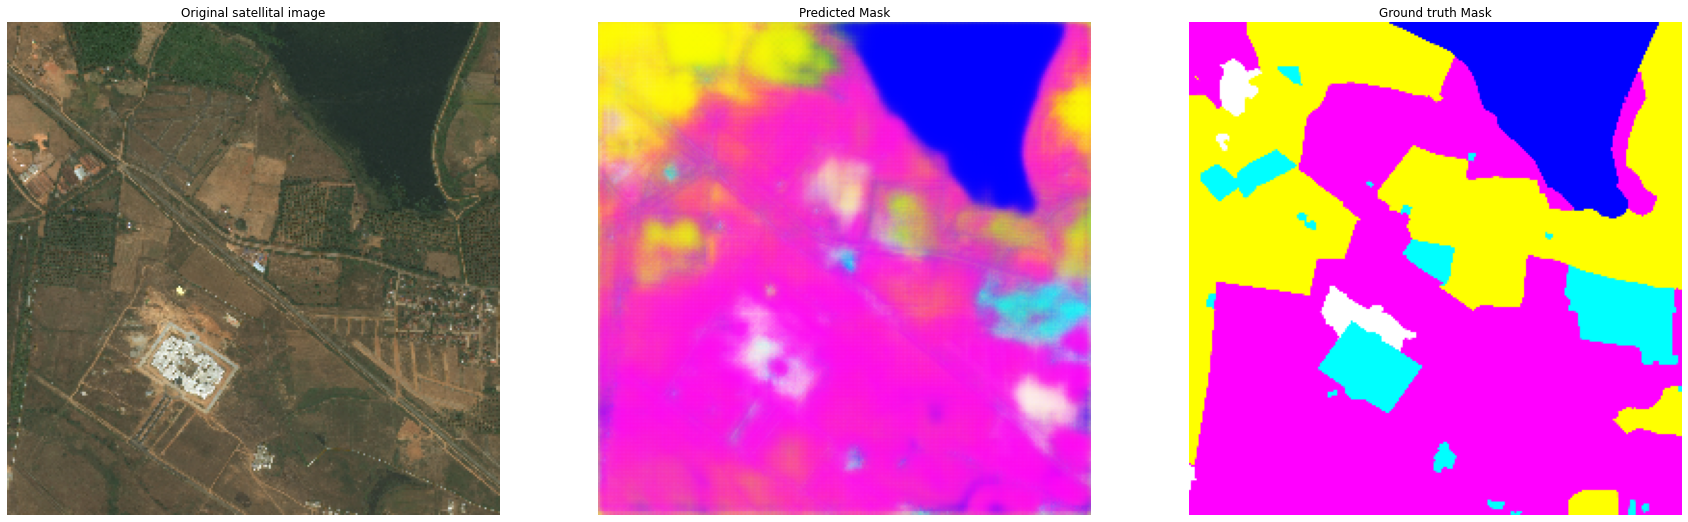

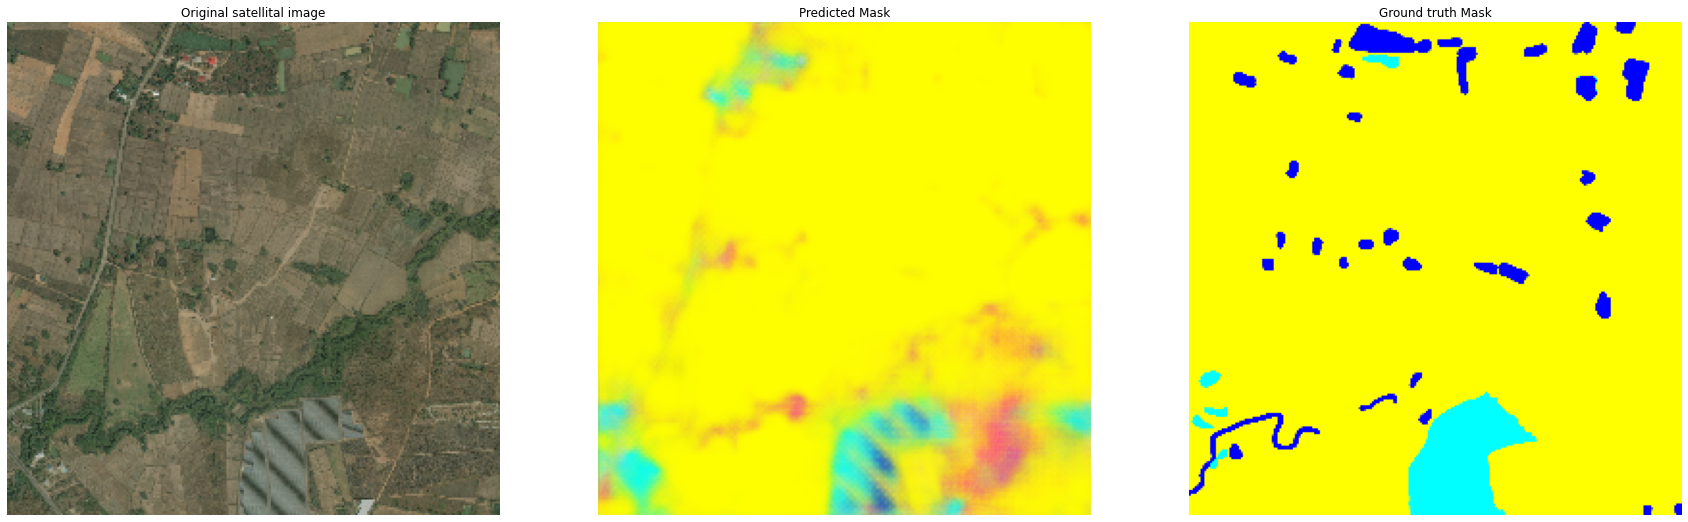

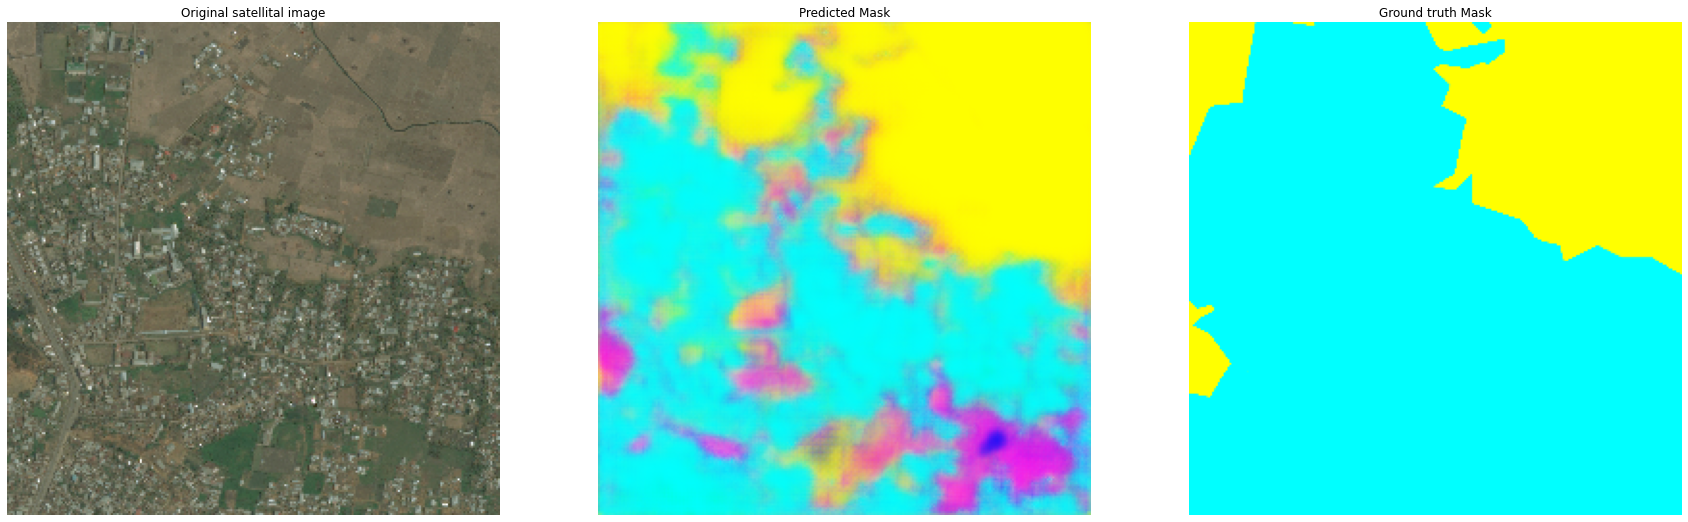

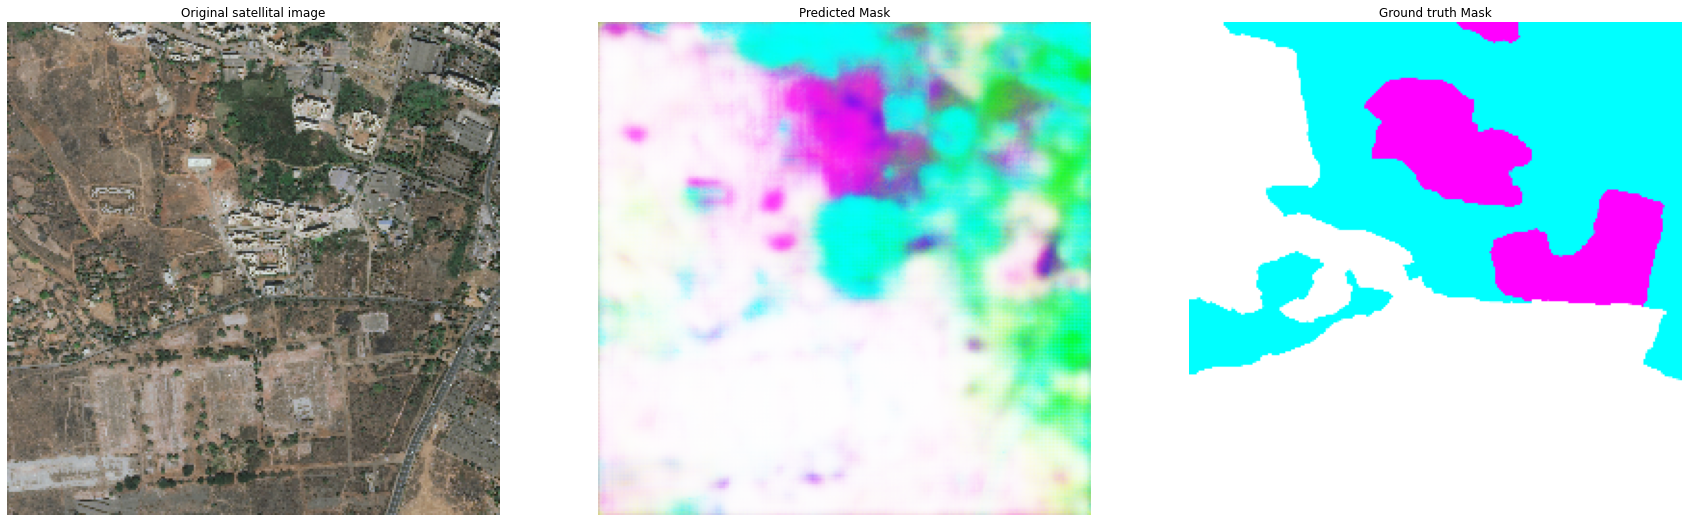

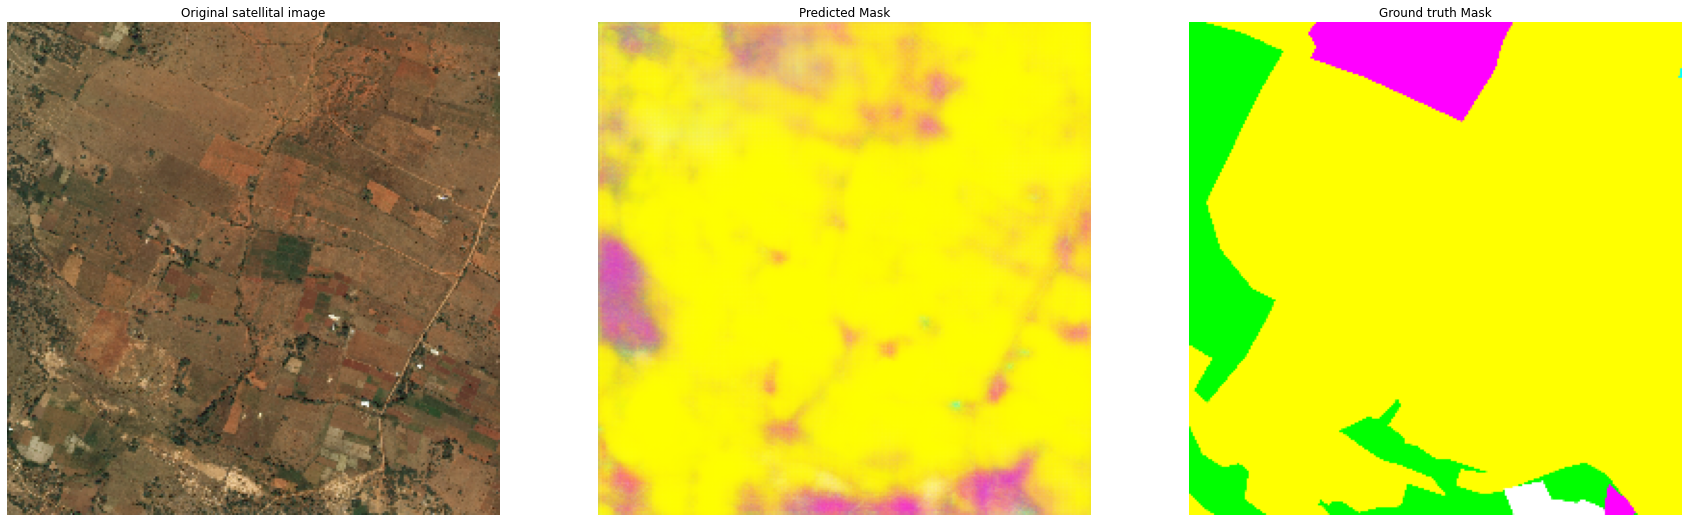

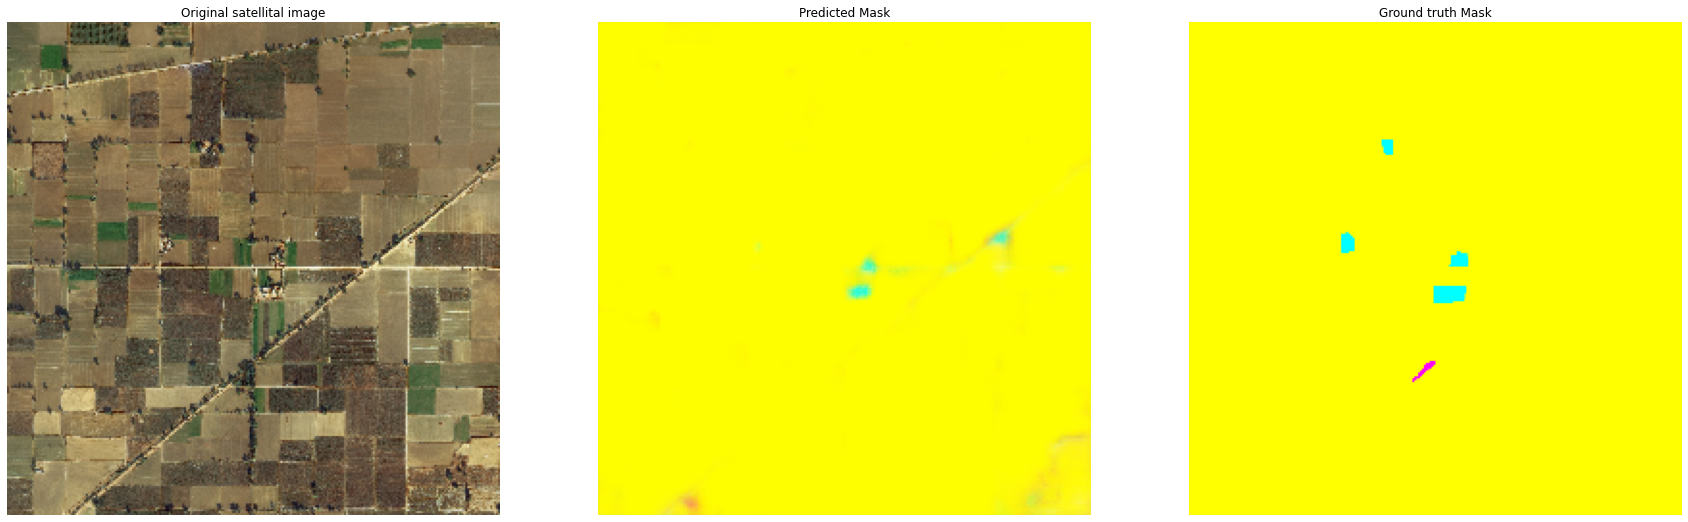

In [ ]:
for i in range(30):
  plot_predictions(imgs[i], predicted_masks[i], masks[i])

## Vision Transformer

# Model export

In [ ]:
joblib.dump('/content/best.hdf5', '/content/drive/MyDrive/personal-projects/land-cover-segmentation/models/best.hdf5')

['/content/drive/MyDrive/personal-projects/land-cover-segmentation/models/best.hdf5']

# Model import

In [ ]:
model2 = joblib.load('/content/drive/MyDrive/personal-projects/land-cover-segmentation/models/best.hdf5')

---
*Let’s change the world, Together!*


<img align=centerright src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F202df933-5432-47f6-aba6-a9a054cece4b%2Fpages-PhotoRoom.png?table=block&id=0b1ffffe-7be4-41f2-86dd-26cad410a64b&spaceId=12eea25e-0790-4a8f-aa1c-b60f93c02da2&width=250&userId=4be5c684-7292-494e-bbb2-2554f1af3879&cache=v2"  width="70" height="70">

<img align=centerright src="https://cdn-icons-png.flaticon.com/512/25/25231.png"  width="70" height="70">
<img align=centerright src="https://cdn-icons-png.flaticon.com/512/61/61109.png?w=360"  width="70" height="70">
<img align=centerright src="https://cdn-icons-png.flaticon.com/512/39/39552.png"  width="70" height="70">
<img align=centerright src="https://cdn.freebiesupply.com/images/large/2x/instagram-icon-white-on-black.png"  width="100" height="70">

[Personal Blog](https://santiagoal.super.site/)      [GitHub](https://github.com/santiagoahl)    [LinkedIn](https://www.linkedin.com/in/santiago-ahumada-lozano/)   [Twitter](https://twitter.com/sahumadaloz)  [Instagram](https://www.instagram.com/santiago_al10/)
